In [1]:
import jax
import numpy as np
import jax.numpy as jnp
from tinygp import kernels
from HeaderP import *

jax.config.update("jax_enable_x64", True)
def bprp_to_teff(bprp):
    """
    Calculate photometric Teff from Gaia color (use dereddened color!)
    Args:
        bprp (array): Gaia G_BP colour minus Gaia G_RP colour.
    Returns:
        teffs (array): Photometric effective temperatures.
    """

    coeffs = [8959.8112335205078, -4801.5566310882568, 1931.4756631851196,
            -2445.9980716705322, 2669.0248055458069, -1324.0671020746231,
            301.13205924630165, -25.923997443169355]
    """
    # Jason's updated parameters:
    coeffs = [-416.585, 39780.0, -84190.5, 85203.9, -48225.9, 15598.5,
              -2694.76, 192.865]
    """

    return np.polyval(coeffs[::-1], bprp)

# sigmaclip cluster data

In [2]:

M67 = pd.read_csv('m67_subset_wphot.csv')
M67['teff_calc'] = M67['Teff']
M67['Age'] = 3.8*np.ones(len(M67))
M67['Cluster'] = 'M67'
M67['M_G'] = m_to_M(M67['phot_g_mean_mag'], 0.85)
M67['Age_err'] = 0.1

oc = pd.read_pickle('/Users/yl4331/Desktop/KeplerAges/clusters.pkl')
oc = oc.sort_values(by='AGE').reset_index(drop=True)
oc['teff_calc'] = bprp_to_teff(oc['BP_RP_0'])
oc['Prot'] = oc['PROT']
oc['Age'] = oc['AGE']/1000
oc['Age_err'] = oc['AGE_err']/1000
oc['Cluster'] = oc['CLUSTER']

oc = pd.concat([oc, M67])
oc['Prot_log'] = np.log10(oc['Prot'])
oc = oc.loc[oc['Age']>0.5]
oc = oc.loc[~(oc['Age']==1.4)]

uniqage = oc['Age'].unique()

0.67
2.5


/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


(0.0, 70.0)

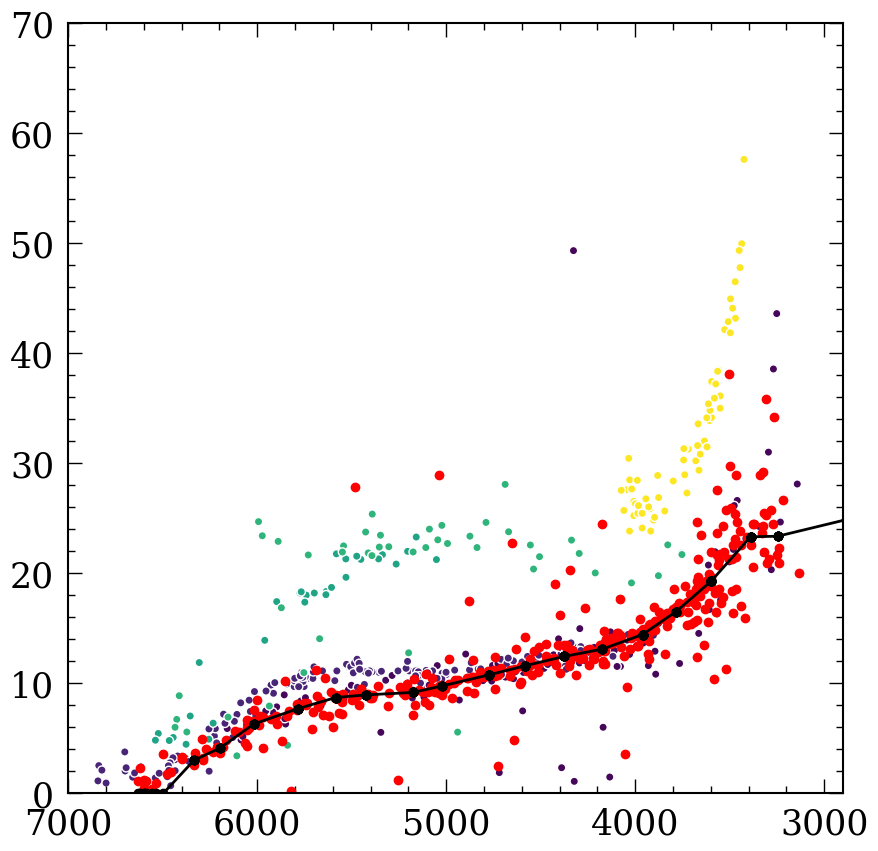

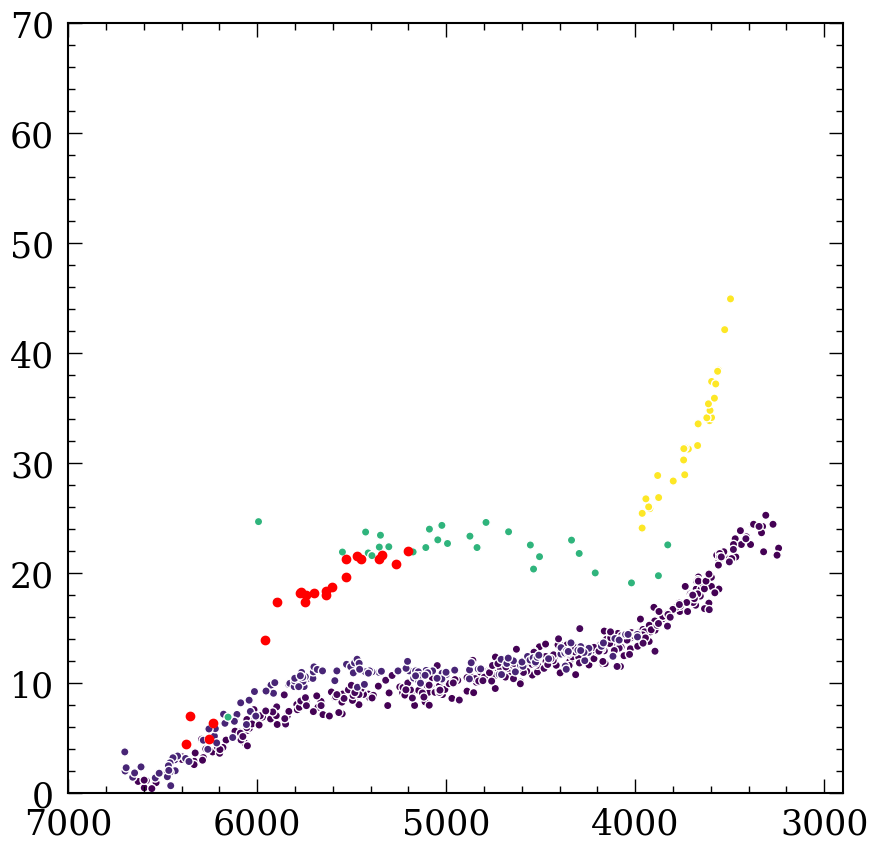

In [3]:


oc = oc.loc[~((oc['teff_calc']<4000)&(oc['Prot']<10))]
oc = oc.loc[~((oc['teff_calc']<3500)&(oc['Prot']<15))]
oc = oc.loc[~((oc['teff_calc']<3400)&(oc['Prot']<20))].reset_index(drop=True)

plt.scatter(oc['teff_calc'], oc['Prot'], c=oc['Age'], edgecolor='w')
noage = 0
m = (oc['Age']==uniqage[noage])
print(uniqage[noage])
plt.plot(oc['teff_calc'][m], oc['Prot'][m], 'ro')
plt.xlim([7000, 2900])
plt.ylim([0,70])

oc = oc.dropna(subset=['teff_calc','Prot'])

from scipy import interpolate
allms = np.zeros(len(oc), dtype=bool)
# sigma clipping clusters
for i in range(len(uniqage)):
    m = (oc['Age']==uniqage[i])
    teffrun, protrun, ind = zip(*(sorted(zip(oc['teff_calc'][m].values, oc['Prot'][m].values, oc['Prot'][m].index))))
    teffrun, protrun = np.array(teffrun), np.array(protrun)
    teffrun_mov, protrun_mov = movingMed_time(teffrun,protrun,10,200)
    teffrun_mov[teffrun_mov==0] = teffrun[teffrun_mov==0]
    protrun_mov[teffrun_mov==0] = protrun[teffrun_mov==0]
    
    f = interpolate.interp1d(teffrun_mov, protrun_mov, fill_value='extrapolate')
    if i==0:
        pcut = interpolate.interp1d(teffrun_mov, protrun_mov, fill_value='extrapolate')
        plt.plot(teffrun_mov, protrun_mov, 'k-o')
    mcut = abs(oc['Prot'][m]-f(oc['teff_calc'][m]))<2
    allms[m] = mcut
    

plt.figure()
oc = oc[allms].reset_index(drop=True)
plt.scatter(oc['teff_calc'], oc['Prot'], c=oc['Age'], edgecolor='w')
noage = 3
m = (oc['Age']==uniqage[noage])
print(uniqage[noage])
plt.plot(oc['teff_calc'][m], oc['Prot'][m], 'ro')
plt.xlim([7000, 2900])
plt.ylim([0,70])

In [4]:
ztf = pd.read_csv('AllztfAge.csv')
ztf['kin_age'] = ztf['kin_age']-0.5
ztf = ztf.loc[ztf['Prot_log']>np.log10(pcut(ztf['teff_calc']))+0.06]
ztf = ztf.loc[ztf['kin_age']<20]
ztf = ztf.loc[ztf['Prot_log']>1]
ztf = ztf.loc[~((ztf['kin_age']<2)&(ztf['teff_calc']<4000))]
ztf = ztf.loc[~((ztf['kin_age']<1.5)&(ztf['teff_calc']>4000))].reset_index(drop=True)


/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_93294/1928728311.py:3: RuntimeWarning: divide by zero encountered in log10
  ztf = ztf.loc[ztf['Prot_log']>np.log10(pcut(ztf['teff_calc']))+0.06]


<AxesSubplot:>

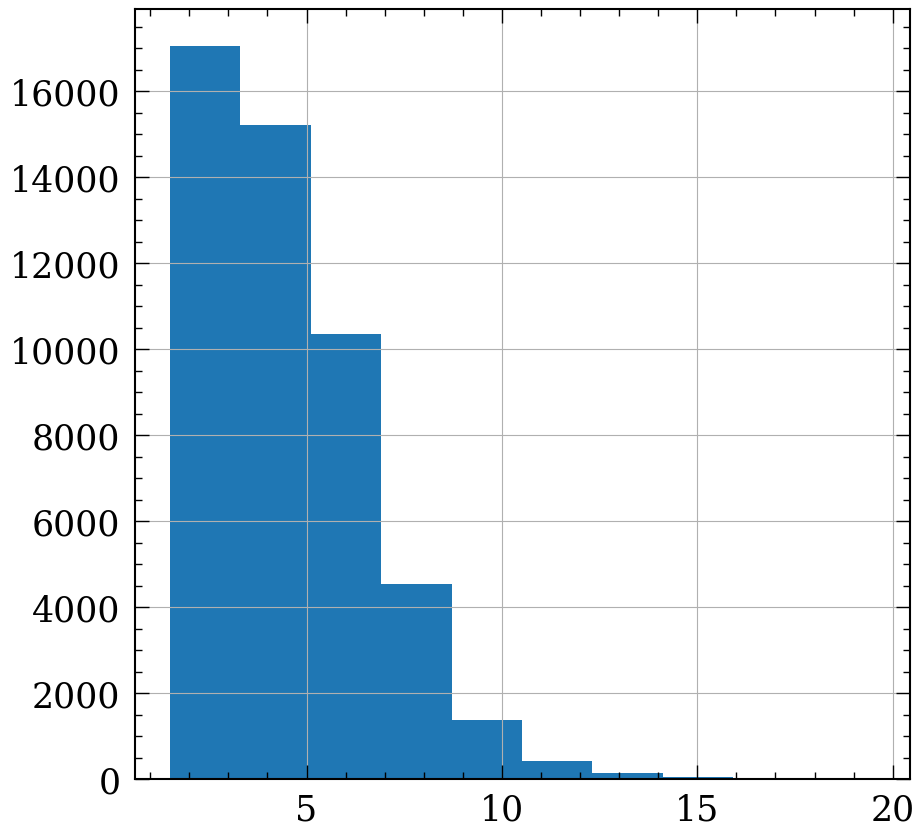

In [5]:
ztf['kin_age'].hist()

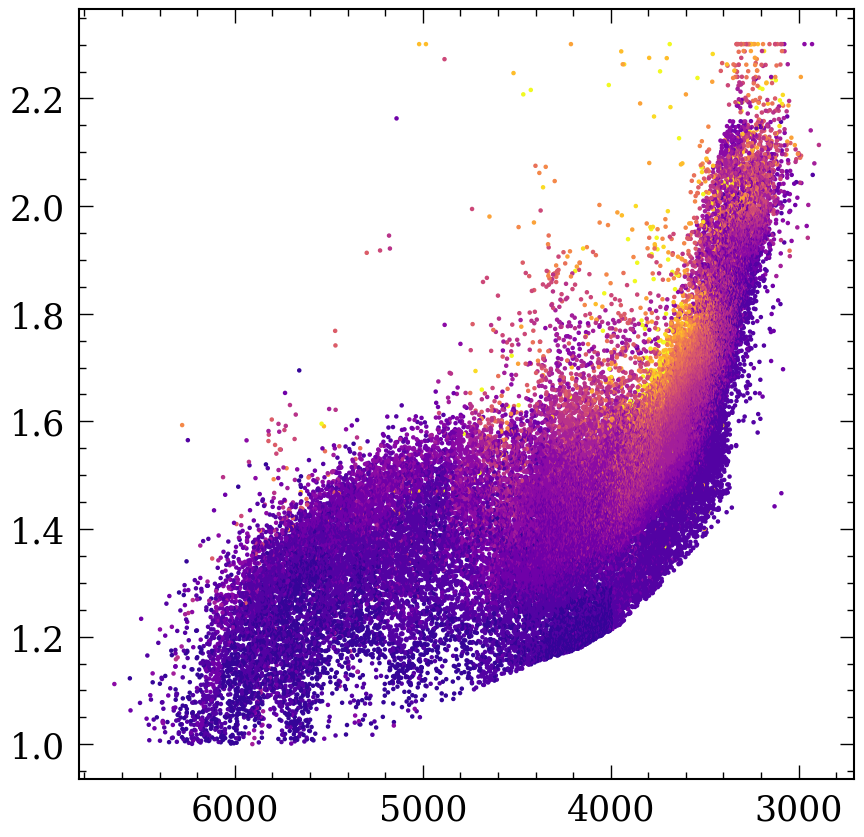

In [6]:
plt.scatter(ztf['teff_calc'], ztf['Prot_log'], c=ztf['kin_age'],
          vmin=0, vmax=15, cmap=plt.get_cmap('plasma',15),s=5)
plt.gca().invert_xaxis()

Text(0, 0.5, 'Age [Gyr]')

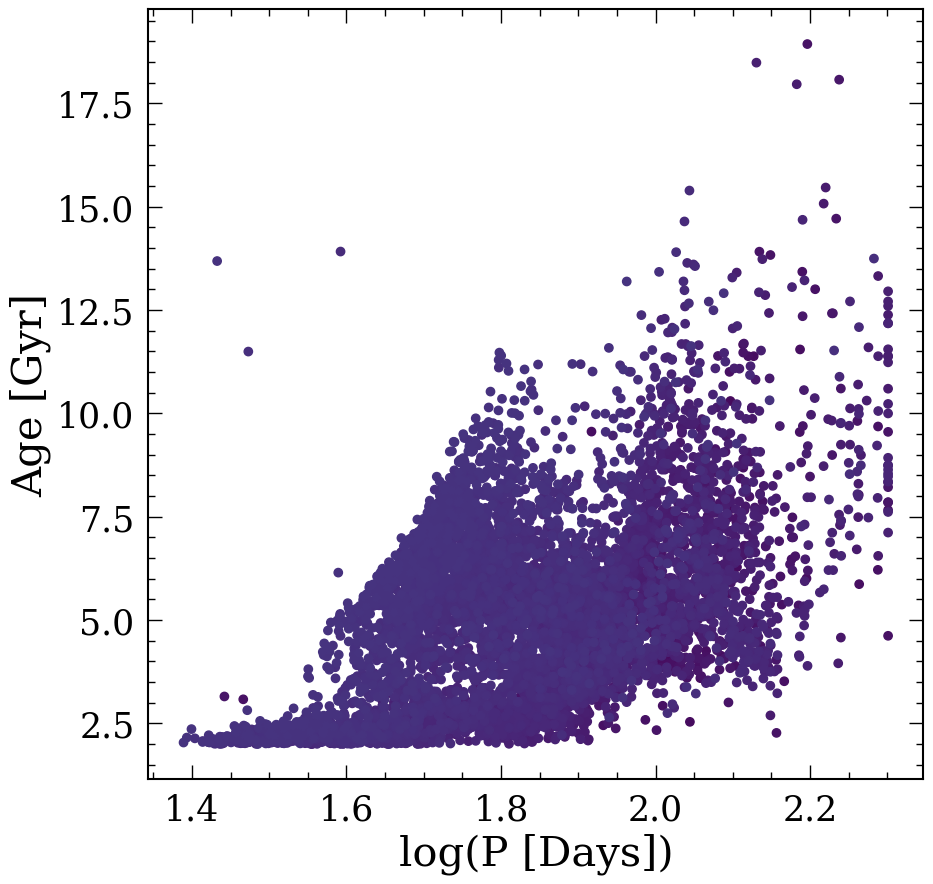

In [7]:
teffsel = [3000, 3500]
m = (ztf['teff_calc']>teffsel[0])&(ztf['teff_calc']<teffsel[1])
plt.scatter(ztf['Prot_log'][m], ztf['kin_age'][m], c=ztf['teff_calc'][m],
           vmin=2900, vmax=7000)
plt.xlabel('log(P [Days])')
plt.ylabel('Age [Gyr]')

3800.0


Text(0, 0.5, 'Age [Gyr]')

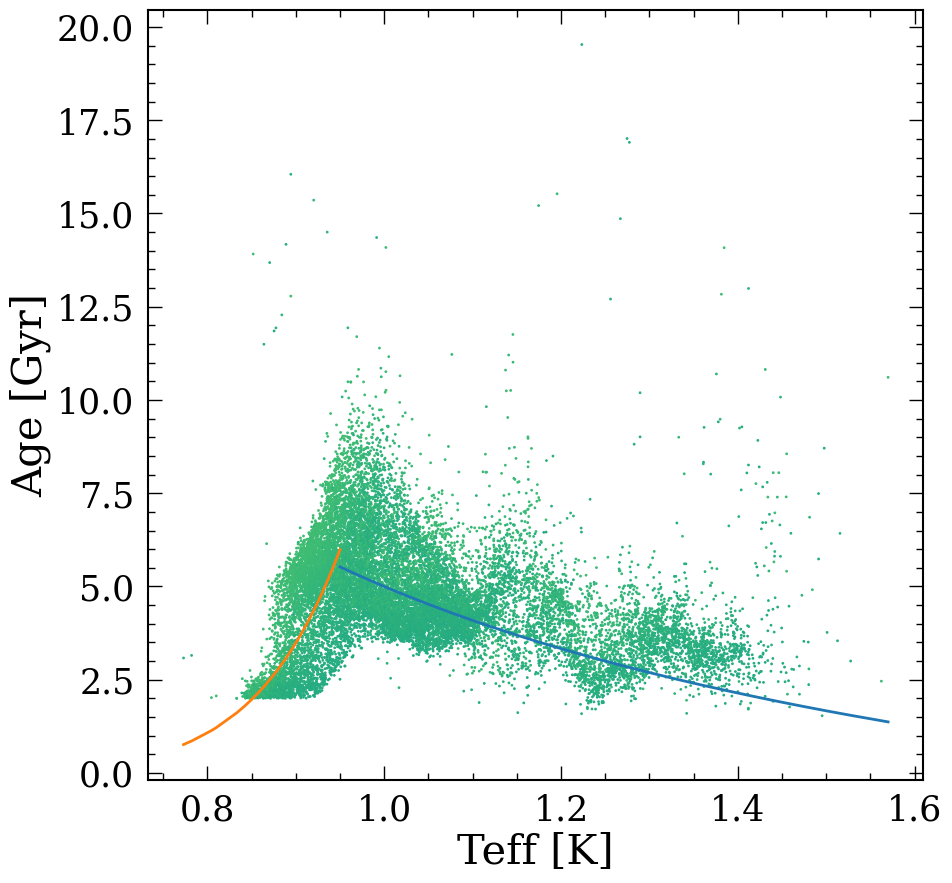

In [8]:
teffsel = [1.4,1.6]
m = (ztf['Prot_log']>teffsel[0])&(ztf['Prot_log']<teffsel[1])
plt.scatter(ztf['teff_calc'][m]/4000, ztf['kin_age'][m], c=ztf['Prot_log'][m],
           vmin=0, vmax=2.3, s=1)

m2 = (ztf['teff_calc'][m]/4000>0.95)
print(0.95*4000)
plt.plot(ztf['teff_calc'][m][m2]/4000, (4000/ztf['teff_calc'][m][m2])**1*10-5)
plt.plot(ztf['teff_calc'][m][~m2]/4000, (4000/ztf['teff_calc'][m][~m2])**-10*10)
plt.xlabel('Teff [K]')
plt.ylabel('Age [Gyr]')


# create prediction grid

In [13]:
# prediction grid
x_grid, y_grid = np.linspace(2900,6500,100), np.linspace(0,2.3,100)
x_, y_ = np.meshgrid(x_grid, y_grid)
y_true = np.zeros((len(y_grid),len(x_grid))) 
m_y = np.zeros((len(y_grid),len(x_grid)), dtype=bool) 

x_sing, y_sing, age_sing, age_sing_err = [], [], [], []
for i in range(len(y_grid)):
    ztf_sing = ztf.loc[abs(ztf['Prot_log']-y_grid[i])<np.diff(y_grid)[0]]
    for j in range(len(x_grid)):
        ztf_sing_new = ztf_sing.loc[abs(ztf_sing['teff_calc']-x_grid[j])<np.diff(x_grid)[0]]['kin_age'].dropna().values
        if len(ztf_sing_new)==0:
            continue 
        else:
            y_sing.append(y_grid[i])
            x_sing.append(x_grid[j])
            age_sing.append(np.median(ztf_sing_new))
            age_sing_err.append(np.std(ztf_sing_new))
            m_y[i,j] = True
            y_true[i,j] = np.median(ztf_sing_new)
            
X_pred = np.vstack((x_.flatten(), y_.flatten())).T


### makeup some mean function

1.6666666666666667
0.16666666666666666 1.3666666666666667


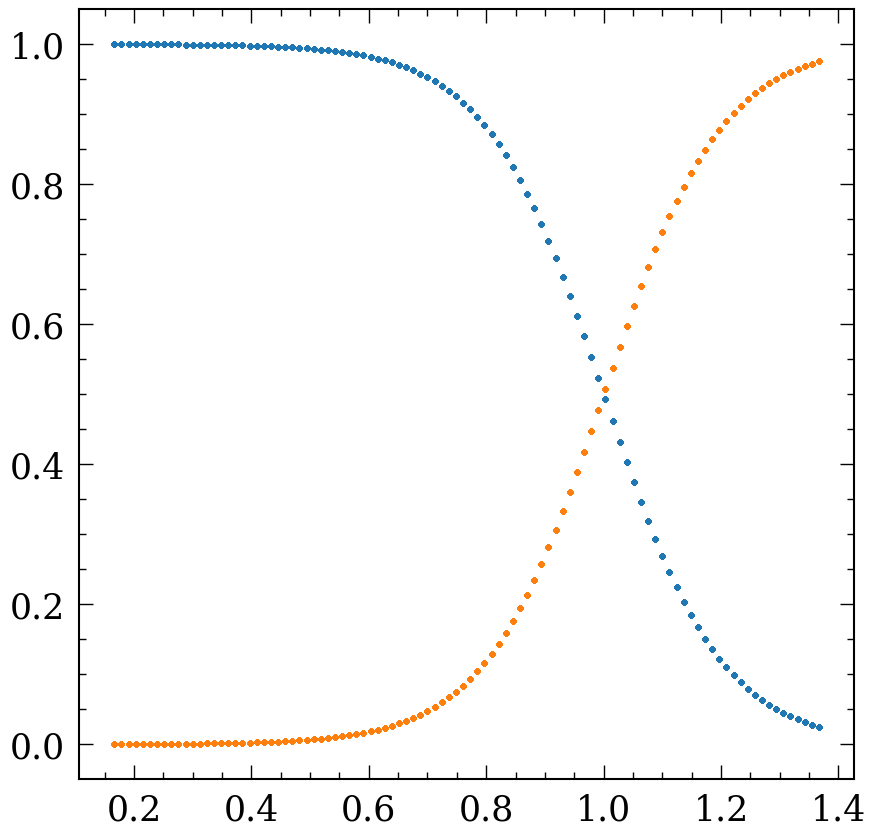

In [14]:
"""plt.plot(X_pred[:,1], 1.0 / (1.0 + np.exp(-(np.log10(20) - X_pred[:,1]) / 0.1)))
plt.plot(X_pred[:,1], 1.0 / (1.0 + np.exp(-(-np.log10(20) + X_pred[:,1]) / 0.1)))"""
teffonrm = (7000-X_pred[:,0])/(7000-4000)
print((7000-2000)/(7000-4000))
print(min(teffonrm), max(teffonrm))
plt.plot(teffonrm, 1.0 / (1.0 + np.exp(-(1 - teffonrm) / 0.1)),'.')
plt.plot(teffonrm, 1.0 / (1.0 + np.exp(-(-1 + teffonrm) / 0.1)),'.')


In [15]:

def mean_function_both(params, X):
    # Prot broken low
    print('pre-normlized Teff: ', min(X[:,0]), max(X[:,0]))
    teffonrm = (7000-X[:,0])/(7000-params["teff_cut"])
    print('normalized Teff: ', min(X[:,0]), max(X[:,0]))
    prot = np.power(10.,X[:,1])
    #stepfunc_low_prot = (abs(X[:,1]-params['prot_cut'])+(X[:,1]-params["prot_cut"]))/2/(X[:,1]-params["prot_cut"]) # switch on if T<teff_cut
    #stepfunc_high_prot = (abs(X[:,1]-params["prot_cut"])+(-X[:,1]+params["prot_cut"]))/2/(-X[:,1]+params["prot_cut"]) # switch on if T>teff_cut
    
    stepfunc_low_prot = 1.0 / (1.0 + np.exp(-(np.log10(params['prot_cut']) - X[:,1]) / params['w']))
    stepfunc_high_prot = 1.0 / (1.0 + np.exp(-(-np.log10(params['prot_cut']) + X[:,1]) / params['w']))
    
    mod_high_prot = np.power(prot,params["b"])
    mod_high_prot = mod_high_prot*stepfunc_high_prot
    
    mod_low_prot = np.power(prot,params["b2"])*np.power(params["prot_cut"],params["b"]-params["b2"])
    mod_low_prot = mod_low_prot*stepfunc_low_prot
    
    prot_func = mod_high_prot+mod_low_prot
    
    # teff broken low
    #stepfunc_low_teff = (abs(X[:,0]-1)+(X[:,0]-1))/2/(X[:,0]-1) # switch on if T<teff_cut
    #stepfunc_high_teff = (abs(X[:,0]-1)+(-X[:,0]+1))/2/(-X[:,0]+1) # switch on if T>teff_cut
    
    stepfunc_high_teff = 1.0 / (1.0 + np.exp(-(1 - teffonrm) / params['w']))
    stepfunc_low_teff = 1.0 / (1.0 + np.exp(-(-1 + teffonrm) / params['w']))
    
    mod_high_teff = np.power(teffonrm-params["c"],params["d"])
    mod_high_teff = mod_high_teff*stepfunc_high_teff
    
    mod_low_teff = np.power(teffonrm-params["c"],params["d2"])*np.power(1-params["c"],params["d"]-params["d2"])
    mod_low_teff = mod_low_teff*stepfunc_low_teff
    teff_func = mod_high_teff+mod_low_teff
    
    print('teff func: ', min(teff_func), max(teff_func))
    print('prot func: ', min(prot_func), max(prot_func))
    
    return params["a"]*prot_func*teff_func

In [16]:
theta_init = {
    "log_amp": 0.,
    "log_scale": np.array([1.,1.]),
    "a": 0.3,
    "b": 1., # power for low prot
    "b2": 0.8, # power for high prot
    "c": -0.5,
    "d": -1., # power for high teff
    "d2": -10, # power for low teff
    "prot_cut":30.,
    "teff_cut":4000.,
    "w": 0.1
}

"""theta_init ={'a':3.38645793,
 'b': 0.97853747,
 'b2': 1.71620067,
 'c': -1.15260929,
 'd': -4.36762873,
 'd2': -2.1169095,
 'log_amp': -2.34286713,
 'log_scale': [-20.5541602 ,   5.27243984],
 'prot_cut': 36.59433877,
 'teff_cut': 3991.70061928,
 'w': -0.06846627}"""


X_pred = np.vstack((x_.flatten(), y_.flatten())).T
print(np.log10(theta_init['prot_cut']))

1.4771212547196624


pre-normlized Teff:  2900.0 6500.0
normalized Teff:  2900.0 6500.0
teff func:  0.08633035941353542 2.0323716260095073
prot func:  1.9743501111561765 199.50944128145878
121.64319827443401


(6500.0, 2900.0)

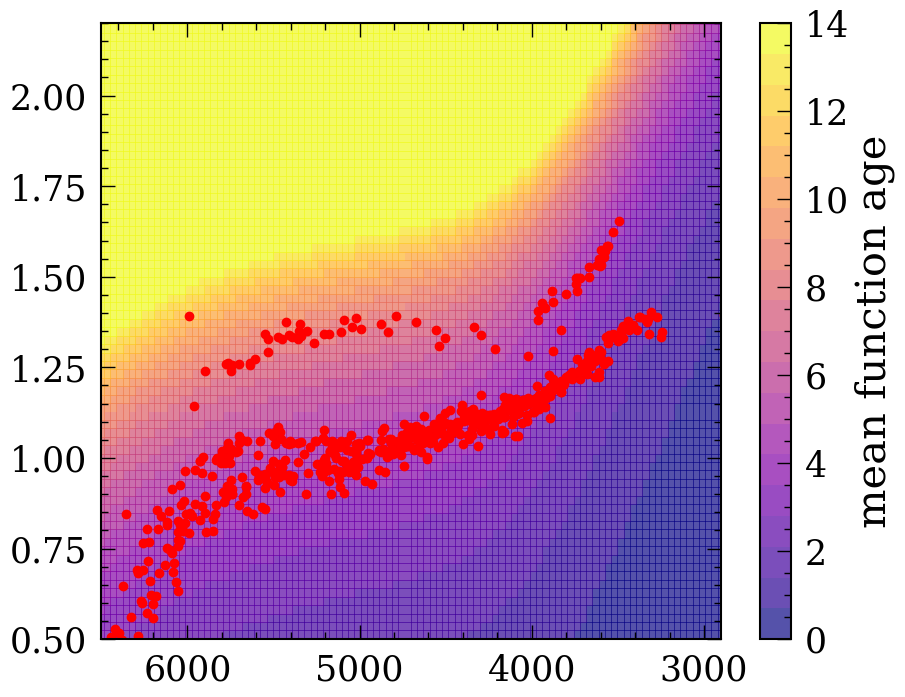

In [18]:
y_mean_int_sing = np.array(mean_function_both(theta_init,X_pred))
y_mean_int = y_mean_int_sing.reshape(np.shape(x_))

print(max(y_mean_int_sing))

plt.figure(figsize=(10,8))
plt.pcolor(x_, y_, y_mean_int, 
           vmin=0, vmax=14,
          cmap=plt.get_cmap('plasma', 20), alpha=0.7)

plt.gca().invert_xaxis()
plt.colorbar(label='mean function age')
plt.plot(oc['teff_calc'], oc['Prot_log'], 'ro')
plt.ylim([0.5,2.2])
plt.xlim([6500, 2900])



# Train GP

## mean function: $\tau$ = $a*P^{b}*(T-c)^{-d}$ for T>4500 one and T<4500 another

In [19]:
import jaxopt
from tinygp import GaussianProcess, kernels, transforms
from functools import partial
    
    

def mean_function(params, X):
    prot = jnp.power(10.,X[1])
    stepfunc_low = (abs(X[0]-params["teff_cut"])+(X[0]-params["teff_cut"]))/2/(X[0]-params["teff_cut"]) # switch on if T<teff_cut
    stepfunc_high = (abs(X[0]-params["teff_cut"])+(-X[0]+params["teff_cut"]))/2/(-X[0]+params["teff_cut"]) # switch on if T>teff_cut
    
    mod_high = jnp.power(X[0]/4000-params["c"],params["d"])
    mod_high = mod_high*stepfunc_high
    
    
    mod_low = jnp.power(X[0]/4000-params["c"],params["d2"])*jnp.power(params["teff_cut"]/4000-params["c"],params["d"]-params["d2"])
    mod_low = mod_low*stepfunc_low
    
    
    return params["a"]*jnp.power(prot,params["b"])*(mod_high+mod_low)


def mean_function_prot(params, X):
    prot = jnp.power(10.,X[1])
    stepfunc_low = (abs(X[1]-params['prot_cut'])+(X[1]-params["prot_cut"]))/2/(X[1]-params["prot_cut"]) # switch on if T<teff_cut
    stepfunc_high = (abs(X[1]-params["prot_cut"])+(-X[1]+params["prot_cut"]))/2/(-X[1]+params["prot_cut"]) # switch on if T>teff_cut
    
    teff_func = (X[0]-params["c"])**-params["d"]
    
    mod_high = jnp.power(prot,params["b"])
    mod_high = mod_high*stepfunc_high
    
    
    mod_low = jnp.power(prot,params["b2"])*jnp.power(params["prot_cut"],params["b"]-params["b2"])
    mod_low = mod_low*stepfunc_low
    
    
    return params["a"]*(mod_high+mod_low)*teff_func


"""def mean_function_both(params, X):
    teffnorm = (7000.-X[0])/(7000.-params["teff_cut"])
    # Prot broken low
    prot = jnp.power(10.,X[1])
    stepfunc_low_prot = 1.0 / (1.0 + jnp.exp(-(jnp.log10(params['prot_cut']) - X[1]) / params['w']))
    stepfunc_high_prot = 1.0 / (1.0 + jnp.exp(-(-jnp.log10(params['prot_cut']) + X[1]) / params['w']))
    
    mod_high_prot = jnp.power(prot,params["b"])
    mod_high_prot = mod_high_prot*stepfunc_high_prot
    
    mod_low_prot = jnp.power(prot,params["b2"])*jnp.power(params["prot_cut"],params["b"]-params["b2"])
    mod_low_prot = mod_low_prot*stepfunc_low_prot
    
    prot_func = mod_high_prot+mod_low_prot
    
    # teff broken low
    stepfunc_low_teff = 1.0 / (1.0 + jnp.exp(-(1. - X[0]) / params['w']))
    stepfunc_high_teff = 1.0 / (1.0 + jnp.exp(-(-1. + X[0]) / params['w']))
    
    
    mod_high_teff = jnp.power(teffnorm-params["c"],params["d"])
    mod_high_teff = mod_high_teff*stepfunc_high_teff
    
    mod_low_teff = jnp.power(teffnorm-params["c"],params["d2"])*jnp.power(1.-params["c"],params["d"]-params["d2"])
    mod_low_teff = mod_low_teff*stepfunc_low_teff
    teff_func = mod_high_teff+mod_low_teff
    
    return params["a"]*prot_func*teff_func
"""

def mean_function_both(params, X):
    # Prot broken low
    teffnorm = (7000.-X[0])/(7000.-params["teff_cut"])
    prot = jnp.power(10.,X[1])
    # Prot broken low
    stepfunc_low_prot = 1.0 / (1.0 + jnp.exp(-(jnp.log10(params['prot_cut']) - X[1]) / abs(params['w'])))
    stepfunc_high_prot = 1.0 / (1.0 + jnp.exp(-(-jnp.log10(params['prot_cut']) + X[1]) / abs(params['w'])))
    
    mod_high_prot = jnp.power(prot,params["b"])
    mod_high_prot = mod_high_prot*stepfunc_high_prot
    
    mod_low_prot = jnp.power(prot,params["b2"])*jnp.power(params["prot_cut"],params["b"]-params["b2"])
    mod_low_prot = mod_low_prot*stepfunc_low_prot
    
    prot_func = mod_high_prot+mod_low_prot
    
    # teff broken low
    stepfunc_high_teff = 1.0 / (1.0 + jnp.exp(-(1. - teffnorm) / abs(params['w'])))
    stepfunc_low_teff = 1.0 / (1.0 + jnp.exp(-(-1. + teffnorm) / abs(params['w'])))
    
    
    mod_high_teff = jnp.power(teffnorm-params["c"],params["d"])
    mod_high_teff = mod_high_teff*stepfunc_high_teff
    
    mod_low_teff = jnp.power(teffnorm-params["c"],params["d2"])*jnp.power(1.-params["c"],params["d"]-params["d2"])
    mod_low_teff = mod_low_teff*stepfunc_low_teff
    teff_func = mod_high_teff+mod_low_teff
    
    return params["a"]*prot_func*teff_func


def build_gp(params, X):
    kernel = jnp.exp(params["log_amp"]) * transforms.Linear(
        jnp.exp(-params["log_scale"]), kernels.ExpSquared()
    )

    return GaussianProcess(
        kernel, X, diag=yerr**2,mean=partial(mean_function_both, params)
    )


def build_gp_corr(params, X):
    kernel = jnp.exp(params["log_amp"]) * transforms.Cholesky.from_parameters(
        jnp.exp(params["log_scale"][:2]),
        params["log_scale"][2:],
        kernels.ExpSquared(),
    )
    return GaussianProcess(kernel, X, diag=yerr**2, 
                           mean=partial(mean_function_both, params))


def neg_log_likelihood(params, X, y):
    gp = build_gp(params, X)
    return -gp.log_probability(y)




# Train on average in each grid

In [20]:
# select same amount based on teff
teffgrid = np.linspace(2900, 6500, 70)
protgrid = np.linspace(0, 2.3, 50)
print(np.diff(teffgrid)[0], np.power(10, np.diff(protgrid)[0]))

numbpick = 5

teffs = []
prots = []
age = []
age_err = []

#tefflens = ztf_sing
count = 0 
for i in trange(len(teffgrid)-1):
    ztf_sing = ztf.loc[(ztf['teff_calc']>teffgrid[i])&(ztf['teff_calc']<teffgrid[i+1])]
    for j in range(len(protgrid)-1):
        ztf_sing_prot = ztf_sing.loc[(ztf_sing['Prot_log']>protgrid[j])&(ztf_sing['Prot_log']<protgrid[j+1])]
        if ((len(ztf_sing_prot)<10)&(teffgrid[i]>4000)) or ((len(ztf_sing_prot)<5)&(teffgrid[i]<=4000)):
            continue
        else:
            teffs.append(teffgrid[i]/2+teffgrid[i+1]/2)
            prots.append(protgrid[j]/2+protgrid[j+1]/2)
            age.append(np.median(ztf_sing_prot['kin_age'].dropna()))
            age_err.append(np.std(ztf_sing_prot['kin_age'].dropna()))
            

52.17391304347848 1.1141374574404606


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 115.38it/s]


In [21]:
ztf_pick = pd.DataFrame(np.array((teffs, prots, age, age_err)).T,
                       columns=['teff_calc','Prot_log','Age','Age_err'])
ztf_pick['cluster'] = 0
#ztf_pick = pd.concat([ztf_pick, ztf.loc[(ztf['teff_calc']<4500)&(ztf['Age']>8)&(ztf['Age']<14)]])

In [22]:
print(len(ztf_pick))
ztf_pick = ztf_pick.dropna(subset=['teff_calc','Prot_log','Age','Age_err'])

ztf_pick['Age_err'] = ztf_pick['Age_err']+1
ztf_sel = ztf_pick.reset_index(drop=True)
print(len(ztf_pick))

639
639


In [23]:
oc['cluster'] = 1
unqage = oc['Age'].unique()
print(unqage)

[0.67 0.73 1.   2.5  2.7  3.8 ]


In [24]:
"""import Astraea
regr, regr_outs = RFregressor(ztf_sel, ['teff_calc','Prot_log'],
                                      target_var='Age', target_var_err='Age_err', 
                                      n_estimators=3)
ztf_sel['Age_prd'] = regr.predict(ztf_sel[regr_outs['actrualF']])
m = abs((ztf_sel['Age_prd']-ztf_sel['Age'])/ztf_sel['Age'])>0.1

plt.scatter(ztf_sel['teff_calc'], ztf_sel['Prot_log'], c=ztf_sel['Age'],
          vmin=0, vmax=15, cmap=plt.get_cmap('plasma',15),s=50)
plt.plot(ztf_sel['teff_calc'][m], ztf_sel['Prot_log'][m], 'ko')

print(len(ztf_sel))
ztf_sel = ztf_sel[~m].reset_index(drop=True)
print(len(ztf_sel))"""

"import Astraea\nregr, regr_outs = RFregressor(ztf_sel, ['teff_calc','Prot_log'],\n                                      target_var='Age', target_var_err='Age_err', \n                                      n_estimators=3)\nztf_sel['Age_prd'] = regr.predict(ztf_sel[regr_outs['actrualF']])\nm = abs((ztf_sel['Age_prd']-ztf_sel['Age'])/ztf_sel['Age'])>0.1\n\nplt.scatter(ztf_sel['teff_calc'], ztf_sel['Prot_log'], c=ztf_sel['Age'],\n          vmin=0, vmax=15, cmap=plt.get_cmap('plasma',15),s=50)\nplt.plot(ztf_sel['teff_calc'][m], ztf_sel['Prot_log'][m], 'ko')\n\nprint(len(ztf_sel))\nztf_sel = ztf_sel[~m].reset_index(drop=True)\nprint(len(ztf_sel))"

In [25]:
print(len(ztf_sel))
oc['Age_err'] = [max([i*0.1, 0.1]) for i in oc['Age']]
ztf_sel = pd.concat([ztf_sel, oc]).dropna(subset=['teff_calc','Prot_log','Age','Age_err'])
ztf_sel = ztf_sel.loc[~((ztf_sel['cluster']==1)&(ztf_sel['teff_calc']>5500))]
print(len(ztf_sel))

639
1092


0.1
1092 0.67


"m = (abs(ztf_sel['Age']-2.7)<0.1)\nplt.plot(ztf_sel['teff_calc'][m], ztf_sel['Prot_log'][m], 'ko')\nm = (oc['Age']==2.7)\nplt.plot(oc['teff_calc'][m], oc['Prot_log'][m], 'ro')\n"

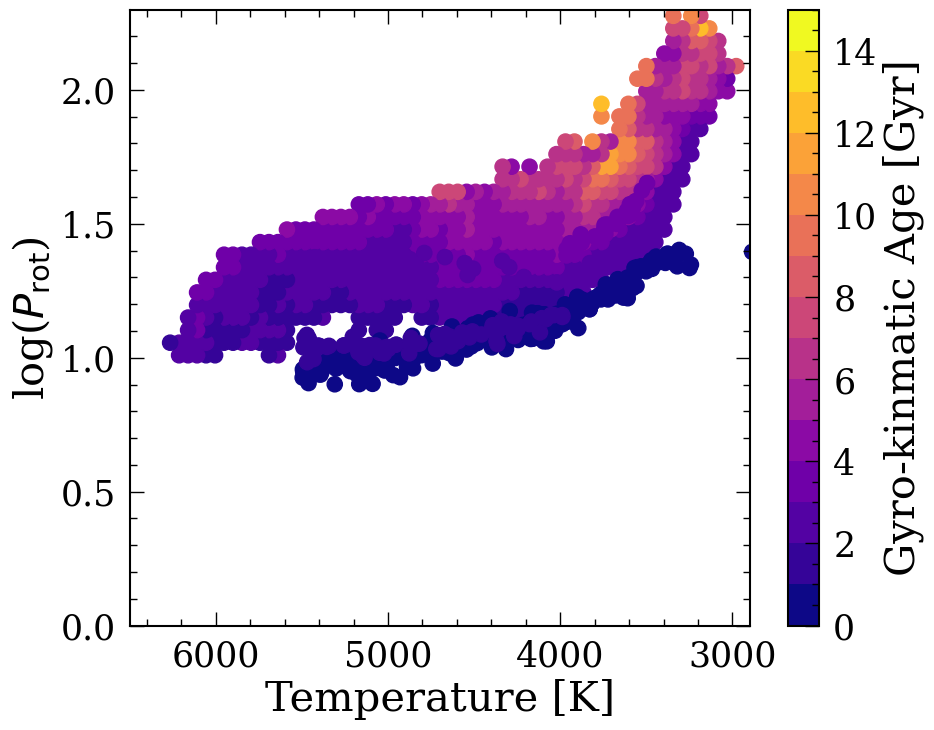

In [26]:
ndim = 2
X = np.array(([ztf_sel['teff_calc'].values, ztf_sel['Prot_log'].values])).T

yerr = ztf_sel['Age_err'].values
print(min(yerr))

y = ztf_sel['Age'].values
plt.figure(figsize=(10,8))
plt.scatter(ztf_sel['teff_calc'], ztf_sel['Prot_log'], c=ztf_sel['Age'],
          vmin=0, vmax=15, cmap=plt.get_cmap('plasma',15),s=120)
plt.xlim([2900,6500])
plt.ylim([0,2.3])
plt.gca().invert_xaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('log($P_{\\rm rot}$)')
plt.colorbar(label='Gyro-kinmatic Age [Gyr]')

print(len(ztf_sel), min(ztf_sel['Age']))


"""m = (abs(ztf_sel['Age']-2.7)<0.1)
plt.plot(ztf_sel['teff_calc'][m], ztf_sel['Prot_log'][m], 'ko')
m = (oc['Age']==2.7)
plt.plot(oc['teff_calc'][m], oc['Prot_log'][m], 'ro')
"""

In [44]:
# prediction grid
x_grid = np.linspace(2900, 6500, 100)
y_grid = np.linspace(0, 2.3, 100)

x_, y_ = np.meshgrid(x_grid, y_grid)
y_true = np.zeros((len(y_grid),len(x_grid))) 
m_y = np.zeros((len(y_grid),len(x_grid)), dtype=bool) 

x_sing, y_sing, age_sing, age_sing_err = [], [], [], []
for i in range(len(y_grid)):
    ztf_sing = ztf_sel.loc[abs(ztf_sel['Prot_log']-y_grid[i])<np.diff(y_grid)[0]]
    for j in range(len(x_grid)):
        ztf_sing_new = ztf_sing.loc[abs(ztf_sing['teff_calc']-x_grid[j])<np.diff(x_grid)[0]]['Age'].dropna().values
        if len(ztf_sing_new)==0:
            continue 
        else:
            y_sing.append(y_grid[i])
            x_sing.append(x_grid[j])
            age_sing.append(np.median(ztf_sing_new))
            age_sing_err.append(np.std(ztf_sing_new))
            m_y[i,j] = True
            y_true[i,j] = np.median(ztf_sing_new)
            
X_pred = np.vstack((x_.flatten(), y_.flatten())).T

In [28]:
# this is for teff broken power law
"""theta_init = {
    "log_amp": 0.,
    "log_scale": np.array([1.,1.]),
    "a": 0.,
    "b": 2.,
    "c": 0.,
    "d": -2.,
    "d2": 10.,
    "teff_cut":3800.
}"""

# this is for prot broken power law
"""theta_init = {
    "log_amp": 0.,
    "log_scale": np.array([1.,1.]),
    "a": 0.,
    "b": 2.,
    "c": 0.,
    "d": 1.,
    "b2": -2.,
    "prot_cut":20.
}"""


# this is for double broken power law
theta_init = {
    "log_amp": -0.30242793,
    "log_scale": np.array([5.96240779, -1.83337922]),
    "a": 0.3,
    "b": 0.79649009, # power for low prot
    "b2": 1.48102877, # power for high prot
    "c": -0.50822617,
    "d": 2.75851643, # power for high teff
    "d2": -12.69918589, # power for low teff
    "prot_cut":42.80952435,
    "teff_cut":3707.1316298,
    "w": 0.1
}

In [29]:
solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
soln = solver.run(theta_init, X=X, y=y)
print(f"Final negative log likelihood: {soln.state.fun_val}")
soln.params

Final negative log likelihood: 818.1410518263833


{'a': DeviceArray(6.12324028e-07, dtype=float64),
 'b': DeviceArray(0.78830392, dtype=float64),
 'b2': DeviceArray(1.42772484, dtype=float64),
 'c': DeviceArray(-1.07185212, dtype=float64),
 'd': DeviceArray(18.1289968, dtype=float64),
 'd2': DeviceArray(-23.5764268, dtype=float64),
 'log_amp': DeviceArray(-1.9111705, dtype=float64),
 'log_scale': DeviceArray([ 5.60281514, -2.67333757], dtype=float64),
 'prot_cut': DeviceArray(39.66867737, dtype=float64),
 'teff_cut': DeviceArray(3928.08232628, dtype=float64),
 'w': DeviceArray(0.0759957, dtype=float64)}

In [30]:
uncorr_gp = build_gp(soln.params, X)
#uncorr_gp = build_gp(theta_init, X)

In [45]:
y_pred = uncorr_gp.condition(y, X_pred).gp.loc.reshape(y_true.shape)

/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_93294/3233764743.py:10: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axes[0].pcolor(x_mask, y_mask, y_pred_mask, vmin=y_true.min(), vmax=y_true.max())
/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_93294/3233764743.py:14: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axes[1].pcolor(x_mask, y_mask, y_pred_mask - y_true_mask)


(0.5, 2.5)

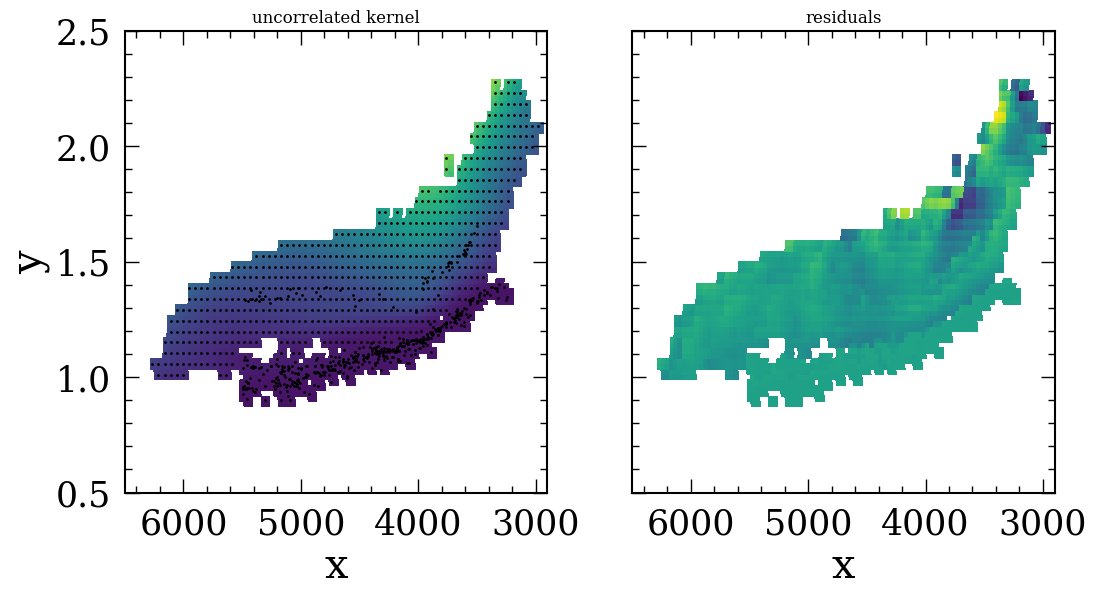

In [46]:
import numpy.ma as ma
x_mask = ma.array(x_, mask = ~m_y)
y_mask = ma.array(y_, mask = ~m_y)
y_pred_mask = ma.array(y_pred, mask = ~m_y)
y_true_mask = ma.array(y_true, mask = ~m_y)

y_mean_mask = ma.array(jax.vmap(uncorr_gp.mean_function)(X_pred).reshape(y_true_mask.shape), mask = ~m_y)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
axes[0].pcolor(x_mask, y_mask, y_pred_mask, vmin=y_true.min(), vmax=y_true.max())
axes[0].scatter(
    X[:, 0], X[:, 1], c='k', vmin=0, vmax=15, s=1
)
axes[1].pcolor(x_mask, y_mask, y_pred_mask - y_true_mask)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[0].set_title("uncorrelated kernel")
axes[1].set_xlabel("x")
_ = axes[1].set_title("residuals")
axes[1].set_xlim([6500, 2900])
axes[0].set_xlim([6500, 2900])
axes[1].set_ylim([0.5,2.5])
axes[0].set_ylim([0.5,2.5])



/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_93294/204982153.py:2: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(x_mask, y_mask, y_pred_mask, vmin=0, vmax=14,
/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_93294/204982153.py:13: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(x_mask, y_mask, y_pred_mask, vmin=0, vmax=14,


(6500.0, 2900.0)

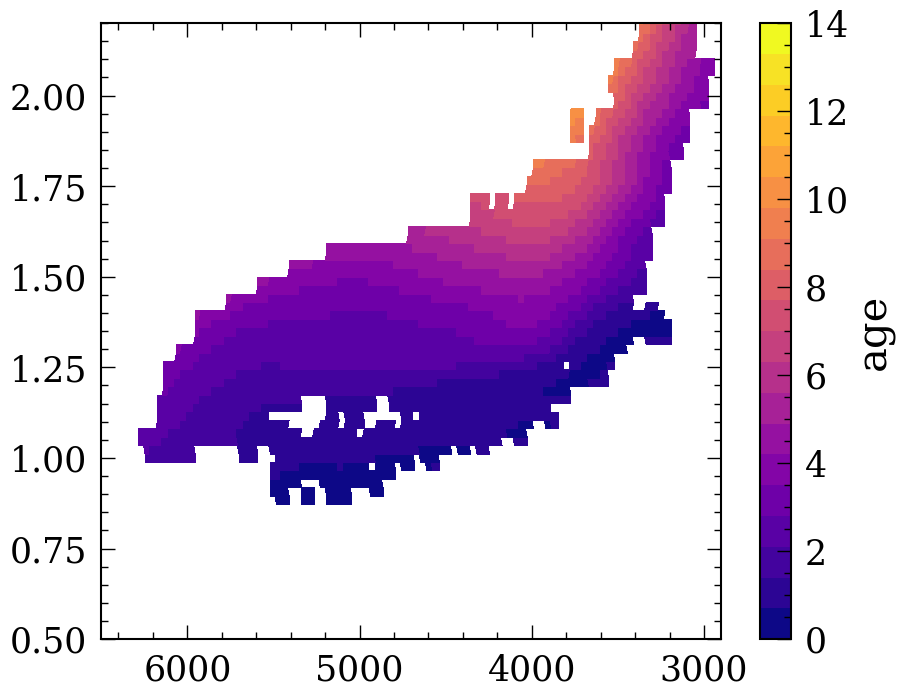

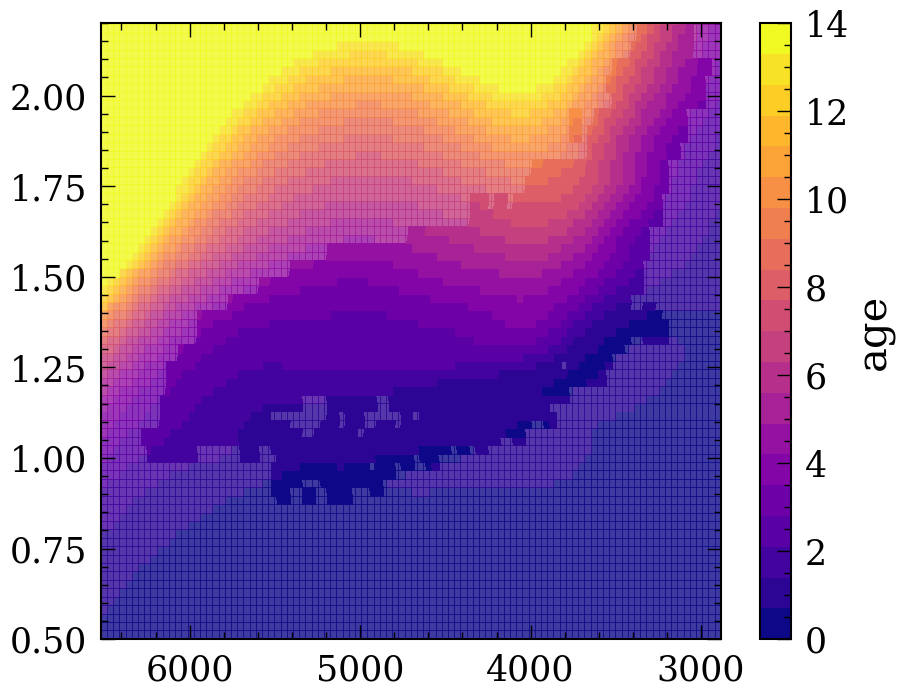

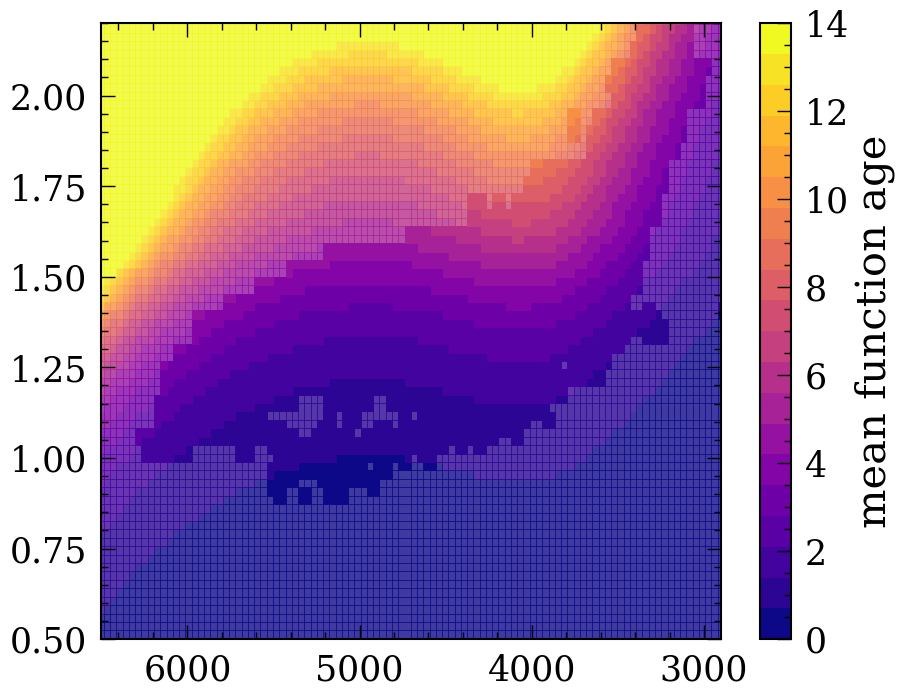

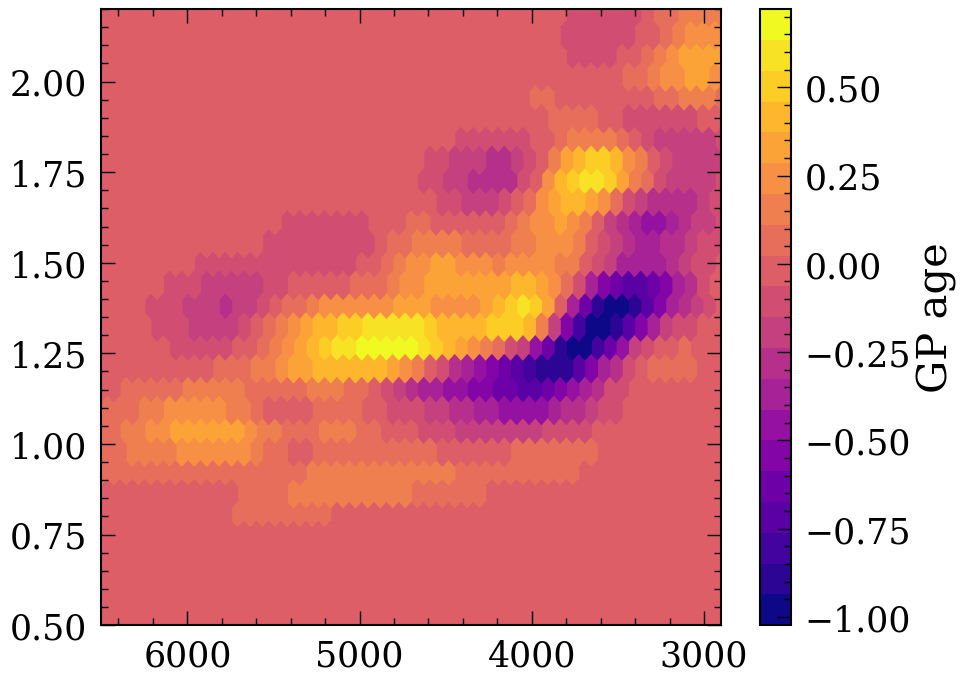

In [47]:
plt.figure(figsize=(10,8))
plt.pcolor(x_mask, y_mask, y_pred_mask, vmin=0, vmax=14,
          cmap=plt.get_cmap('plasma', 20))
plt.gca().invert_xaxis()
plt.colorbar(label='age')

plt.ylim([0.5,2.2])


plt.figure(figsize=(10,8))
plt.pcolor(x_, y_, y_pred, vmin=0, vmax=14,
          cmap=plt.get_cmap('plasma', 20), alpha=0.8)
plt.pcolor(x_mask, y_mask, y_pred_mask, vmin=0, vmax=14,
          cmap=plt.get_cmap('plasma', 20))
plt.gca().invert_xaxis()
plt.colorbar(label='age')

plt.ylim([0.5,2.2])



############# GP model ############# GP model ############# GP model
_, cond = uncorr_gp.condition(y, X_pred, include_mean=False)

mu = cond.loc
std = np.sqrt(cond.variance)
#plt.fill_between(X_pred, mu + std, mu - std, color="C0", alpha=0.3)
############# GP model ############# GP model ############# GP model

plt.figure(figsize=(10,8))
plt.pcolor(x_, y_, jax.vmap(uncorr_gp.mean_function)(X_pred).reshape(y_true.shape), 
           vmin=0, vmax=14,
          cmap=plt.get_cmap('plasma', 20), alpha=0.8)

plt.pcolor(x_, y_, y_mean_mask, 
           vmin=0, vmax=14,
          cmap=plt.get_cmap('plasma', 20))
plt.gca().invert_xaxis()
plt.colorbar(label='mean function age')
plt.ylim([0.5,2.2])
plt.xlim([6500, 2900])

plt.figure(figsize=(10,8))

plt.hexbin(X_pred[:,0], X_pred[:,1], C=mu, extent=(2900, 6500, 0, 2.3),
           gridsize=(50,20),
           cmap=plt.get_cmap('plasma', 20))
plt.gca().invert_xaxis()
plt.colorbar(label='GP age')
plt.ylim([0.5,2.2])
plt.xlim([6500, 2900])

In [48]:
teff_pred_sing = []
logprot_pred_sing = []
age_pred_sing = []

for i in range(len(x_grid)):
    for j in range(len(y_grid)):
        if y_pred_mask.mask[j,i]==False:
            teff_pred_sing.append(x_grid[i])
            logprot_pred_sing.append(y_grid[j])
            age_pred_sing.append(y_pred_mask.data[j,i])

"""for i in range(len(x_grid)):
    for j in range(len(y_grid)):
        teff_pred_sing.append(x_grid[i])
        logprot_pred_sing.append(y_grid[j])
        age_pred_sing.append(y_pred_mask.data[j,i])"""
        

age_pred_sing = np.array(age_pred_sing)
logprot_pred_sing = np.array(logprot_pred_sing)
teff_pred_sing = np.array(teff_pred_sing)

min(age_pred_sing), max(age_pred_sing)



(0.6318551041341199, 10.693067472220347)

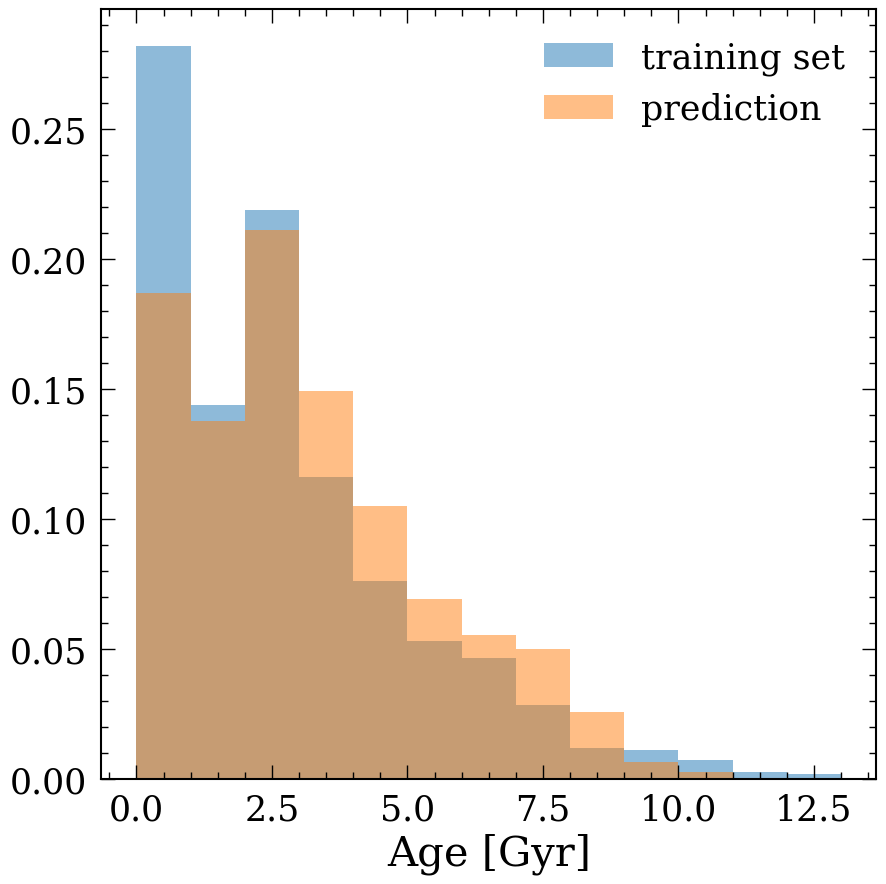

In [49]:
plt.hist(y, bins=np.linspace(0,13,14), alpha=0.5, label='training set',
        density=True)
plt.hist(age_pred_sing, bins=np.linspace(0,13,14), alpha=0.5, label='prediction',
        density=True)
plt.xlabel('Age [Gyr]')
plt.legend(loc=1)

[0.67 0.73 1.   2.5  2.7  3.8 ]


/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_93294/3701651147.py:17: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(x_mask, y_mask, y_pred_mask, vmin=0, vmax=10,


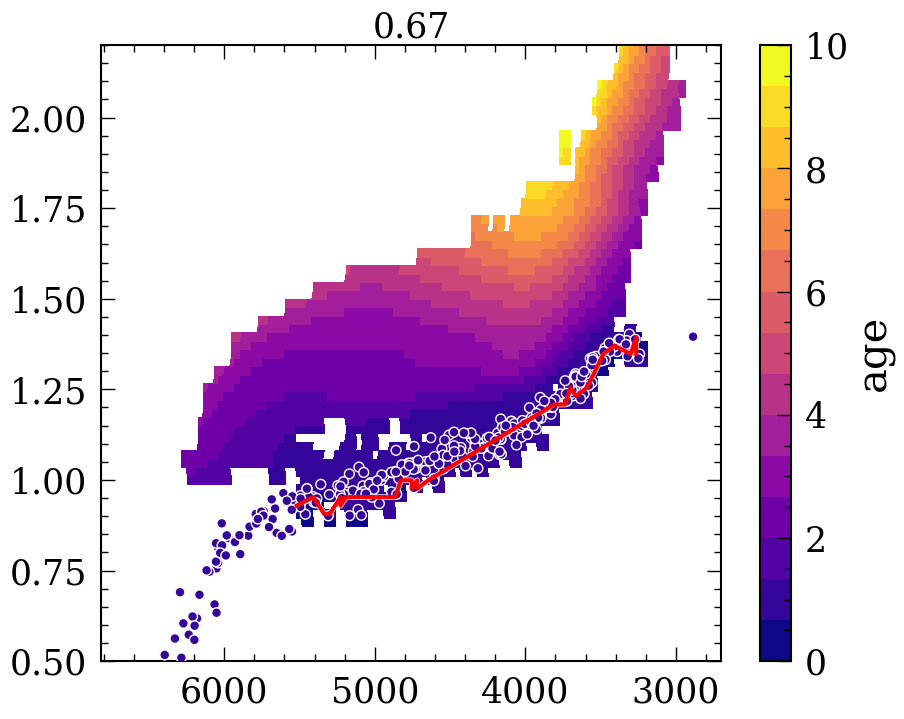

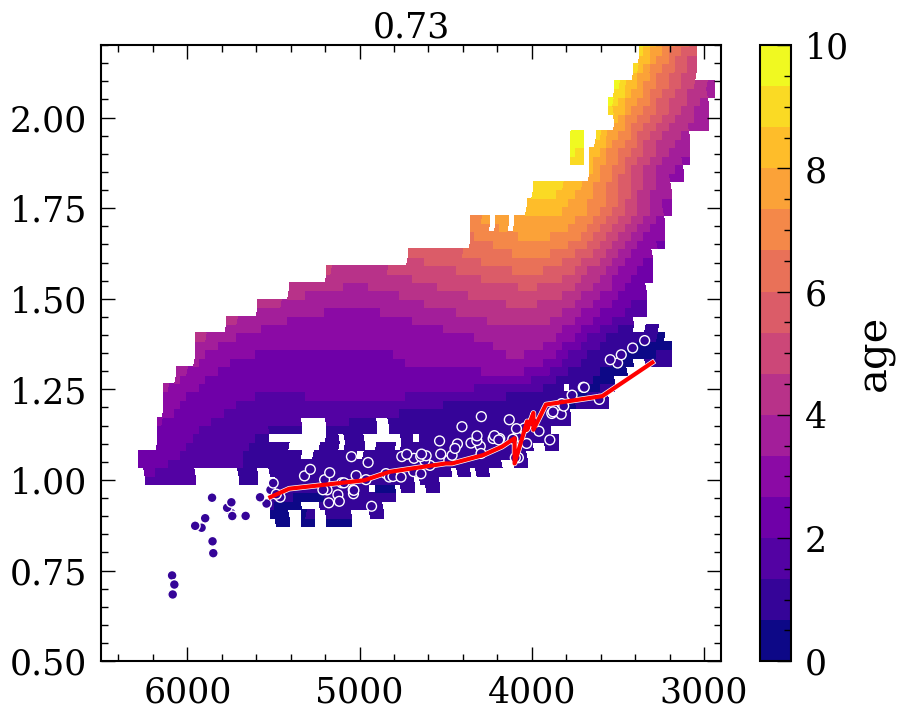

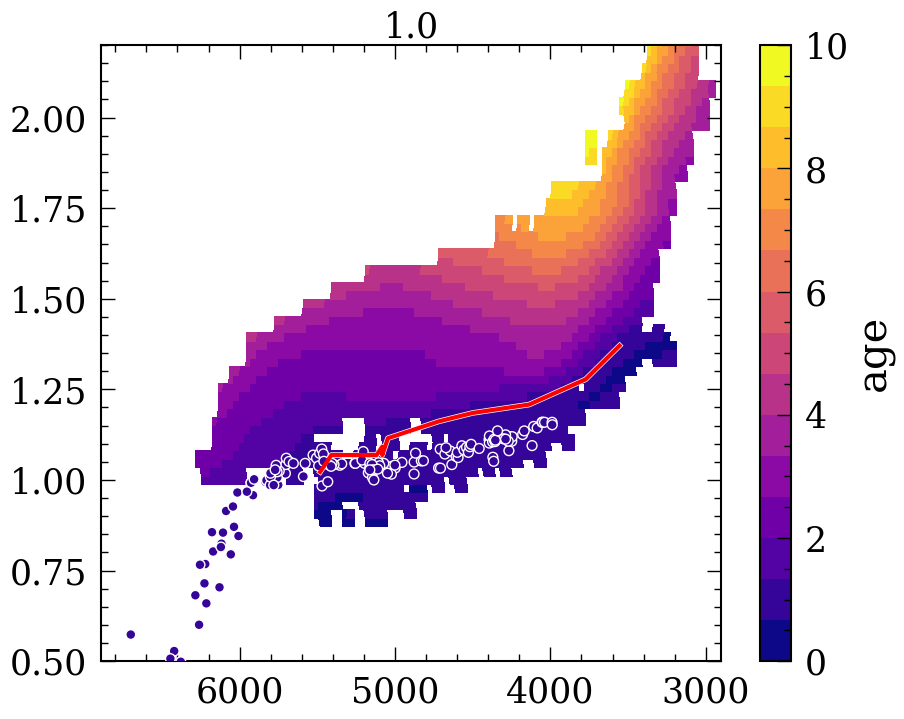

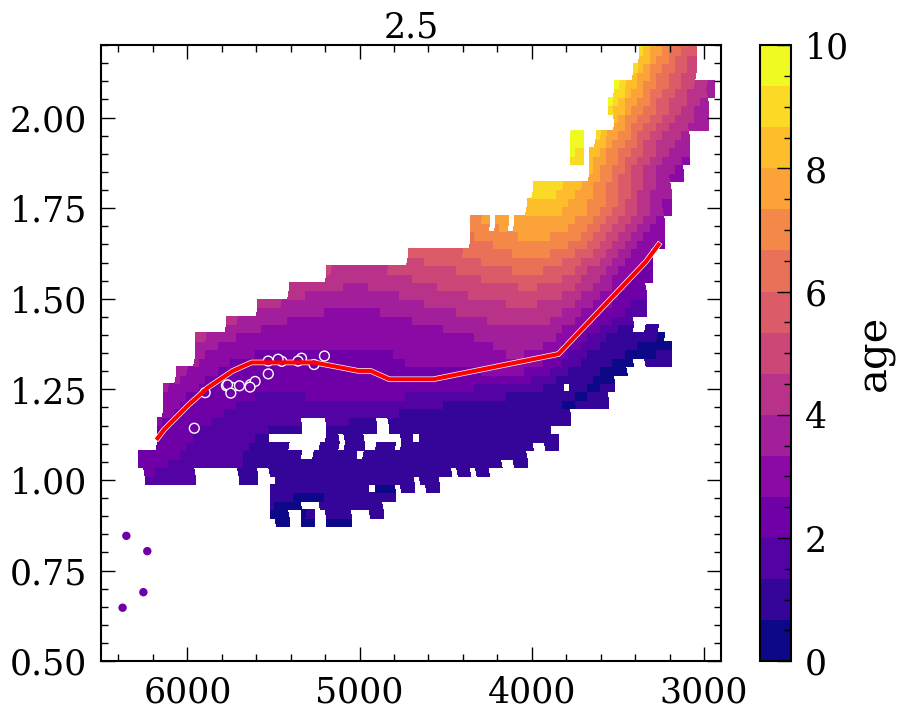

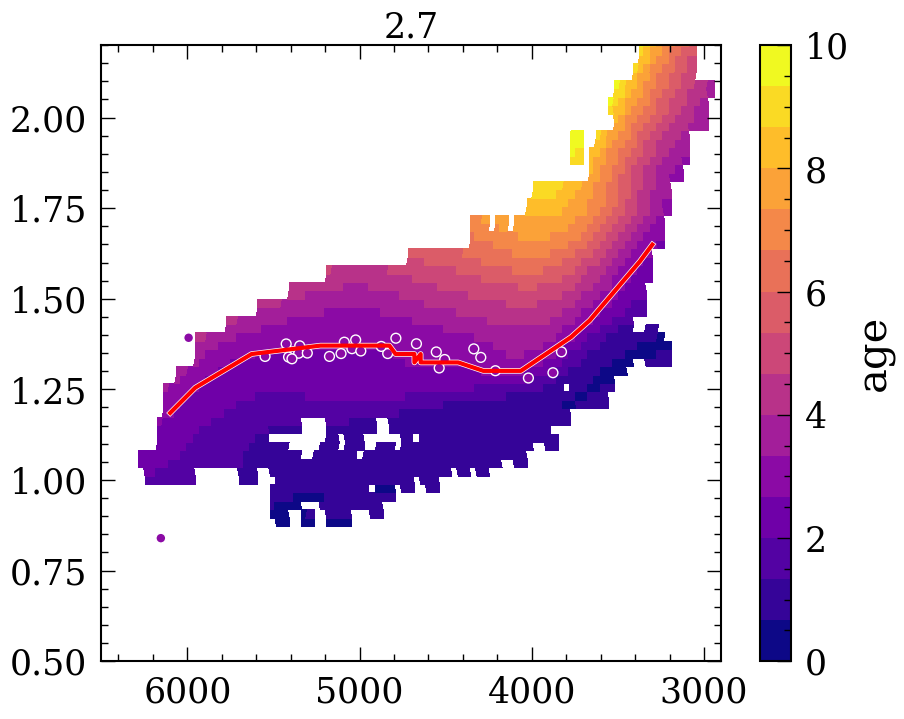

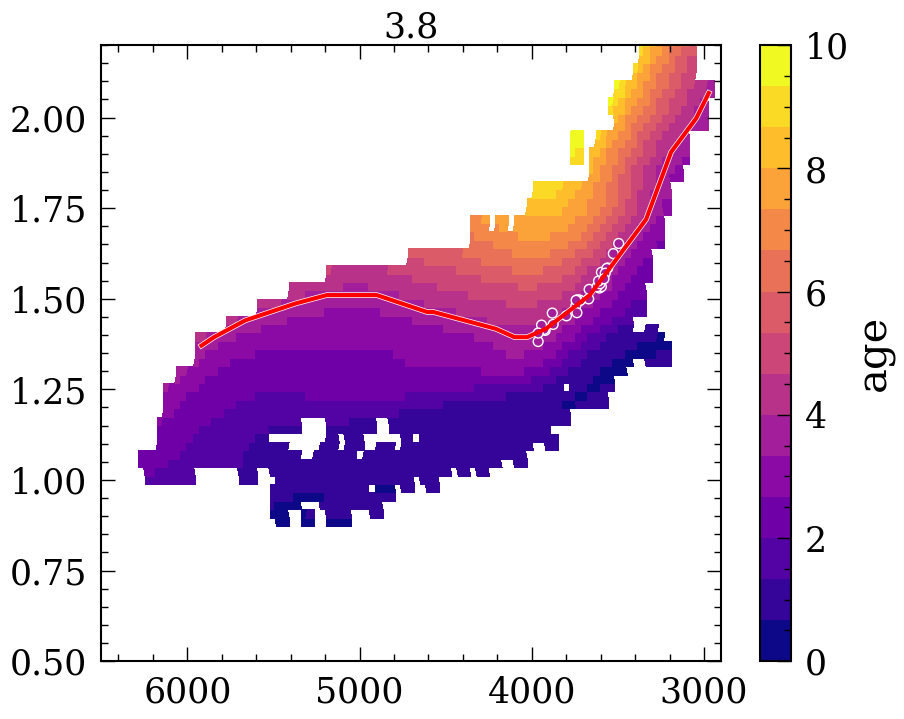

In [52]:

#ageplot = uniqage[4]
uniqage_plot = uniqage[uniqage>0]
print(uniqage_plot)
ageplot = 3.8

"""plt.figure(figsize=(10,8))
plt.pcolor(x_mask, y_mask, y_pred_mask, vmin=0, vmax=10,
          cmap=plt.get_cmap('plasma', 15))"""

colors = getcolor(sorted(np.append([y_true.min(),10],uniqage_plot)))

for i in range(len(uniqage_plot)):
    ageplot = uniqage_plot[i]
    m = (abs(age_pred_sing-ageplot)<ageplot*0.01)
    teff_plot, logprot_plot = zip(*sorted(zip(teff_pred_sing[m], logprot_pred_sing[m])))
    plt.figure(figsize=(10,8))
    plt.pcolor(x_mask, y_mask, y_pred_mask, vmin=0, vmax=10,
          cmap=plt.get_cmap('plasma', 15))
    plt.plot(teff_plot, logprot_plot, color='w', linewidth=4)
    oc_sing = oc.loc[oc['Age']==ageplot]
    plt.scatter(oc_sing['teff_calc'], np.log10(oc_sing['Prot']), c=oc_sing['Age'],
               cmap=plt.get_cmap('plasma', 15), vmin=0, vmax=10,
               edgecolor='w',s=50, zorder=10)
    plt.plot(teff_plot, logprot_plot, color='r', linewidth=3, zorder=10)
    plt.title(str(ageplot), fontsize=25)
    plt.gca().invert_xaxis()
    plt.colorbar(label='age')
    plt.ylim([0.5,2.2])




1.0
1.4736842105263157
1.9473684210526314
2.4210526315789473
2.894736842105263
3.3684210526315788
3.8421052631578947
4.315789473684211
4.789473684210526
5.263157894736842
5.7368421052631575
6.2105263157894735
6.684210526315789
7.157894736842105
7.63157894736842
8.105263157894736
8.578947368421051
9.052631578947368
9.526315789473683
10.0


/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_93294/520405750.py:5: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(x_mask, y_mask, y_pred_mask, vmin=0, vmax=10,


(0.5, 2.2)

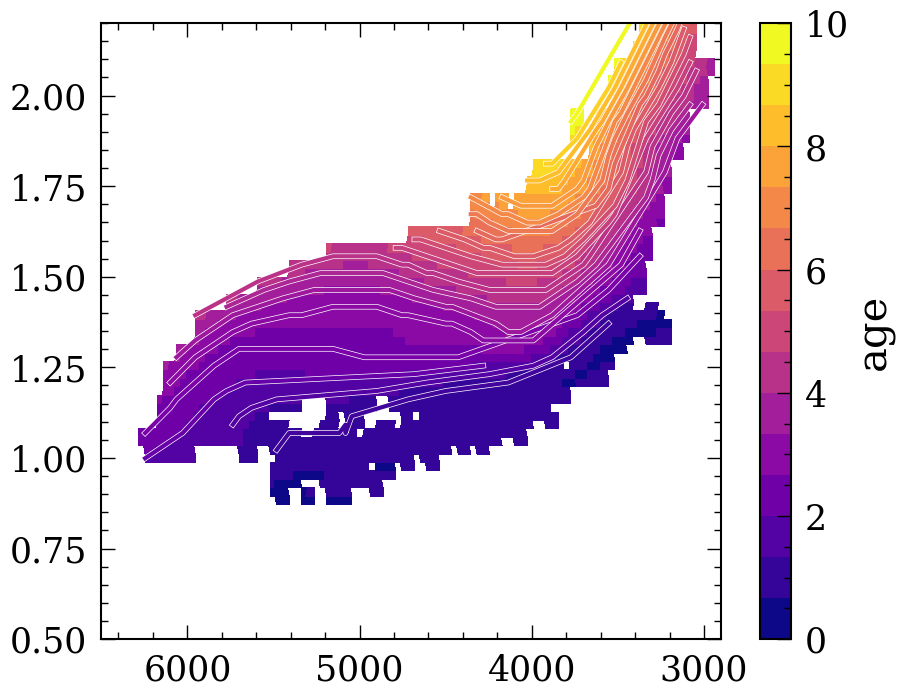

In [53]:
randomage = np.linspace(1, 10, 20)
plt.figure(figsize=(10,8))


plt.pcolor(x_mask, y_mask, y_pred_mask, vmin=0, vmax=10,
          cmap=plt.get_cmap('plasma', 15))

colors = getcolor(sorted(np.append([0,10],randomage)))

for i in range(len(randomage)):
    ageplot = randomage[i]
    print(ageplot)
    m = (abs(age_pred_sing-ageplot)<ageplot*0.01)
    teff_plot, logprot_plot = zip(*sorted(zip(teff_pred_sing[m], logprot_pred_sing[m])))
    plt.plot(teff_plot, logprot_plot, color='w', linewidth=4)
    plt.plot(teff_plot, logprot_plot, color=colors[i+1], linewidth=3)

plt.gca().invert_xaxis()
plt.colorbar(label='age')
plt.ylim([0.5,2.2])





# Select even sampling of data

In [366]:
"""# select same amount based on teff
teffgrid = np.linspace(2900, 6500, 50)
protgrid = np.linspace(0, 2.3, 50)

numbpick = 20

agescat = np.zeros((len(teffgrid), len(protgrid)))
#tefflens = ztf_sing
count = 0 
for i in trange(len(teffgrid)-1):
    ztf_sing = ztf.loc[(ztf['teff_calc']>teffgrid[i])&(ztf['teff_calc']<teffgrid[i+1])]
    for j in range(len(protgrid)-1):
        ztf_sing_prot = ztf_sing.loc[(ztf_sing['Prot_log']>protgrid[j])&(ztf_sing['Prot_log']<protgrid[j+1])]
        if len(ztf_sing_prot)<10:
            continue
        else:
            agescat[i, j] = np.std(ztf_sing_prot['kin_age'].dropna())
            if count==0:
                ztf_pick = ztf_sing_prot.sample(min([len(ztf_sing_prot), numbpick]))
                ztf_pick['age_err'] =  np.std(ztf_sing_prot['kin_age'].dropna())
            else:
                ztf_sing_selc = ztf_sing_prot.sample(min([len(ztf_sing_prot), numbpick]))
                ztf_sing_selc['age_err'] = np.std(ztf_sing_prot['kin_age'].dropna())
                ztf_pick = pd.concat([ztf_pick, ztf_sing_selc])
            count = count+1
    
len(ztf_pick)

ztf_pick['cluster'] = 0

agescat = agescat[agescat!=0]
np.mean(agescat)

ztf_pick['age_err'] = ztf_pick['age_err']+1.5


ztf_pick['Age'] = ztf_pick['kin_age']
ztf_pick['Age_err'] = ztf_pick['age_err']

print(len(ztf_pick))
ztf_pick = ztf_pick.dropna(subset=['teff_calc','Prot_log','Age','Age_err'])
print(len(ztf_pick))

ztf_pick = ztf_pick.loc[ztf_pick['Age']>1.4]
ztf_pick = ztf_pick.loc[ztf_pick['Prot_log']>1]
#p = fitpoints([3000,5000],[1.4,1])
#ztf_pick = ztf_pick.loc[ztf_pick['Prot_log']>p(ztf_pick['teff_calc'])]
len(ztf_pick)
"""

"# select same amount based on teff\nteffgrid = np.linspace(2900, 6500, 50)\nprotgrid = np.linspace(0, 2.3, 50)\n\nnumbpick = 20\n\nagescat = np.zeros((len(teffgrid), len(protgrid)))\n#tefflens = ztf_sing\ncount = 0 \nfor i in trange(len(teffgrid)-1):\n    ztf_sing = ztf.loc[(ztf['teff_calc']>teffgrid[i])&(ztf['teff_calc']<teffgrid[i+1])]\n    for j in range(len(protgrid)-1):\n        ztf_sing_prot = ztf_sing.loc[(ztf_sing['Prot_log']>protgrid[j])&(ztf_sing['Prot_log']<protgrid[j+1])]\n        if len(ztf_sing_prot)<10:\n            continue\n        else:\n            agescat[i, j] = np.std(ztf_sing_prot['kin_age'].dropna())\n            if count==0:\n                ztf_pick = ztf_sing_prot.sample(min([len(ztf_sing_prot), numbpick]))\n                ztf_pick['age_err'] =  np.std(ztf_sing_prot['kin_age'].dropna())\n            else:\n                ztf_sing_selc = ztf_sing_prot.sample(min([len(ztf_sing_prot), numbpick]))\n                ztf_sing_selc['age_err'] = np.std(ztf_sing_pro

# Train correlated kernel

In [ ]:
from sympy import *

T, τ, P= var('T τ P')
bprp = teff_bprp(T)

expr = τ**0.55*0.4*(bprp-0.45)**0.31-P

τ = solve(expr, τ)

In [25]:
τ[0]

2.25825468601231*(P/(4.89648042950014e-23*T**6 - 1.25866053820097e-18*T**5 + 9.99424368382807e-15*T**4 - 1.25587693229949e-11*T**3 - 1.37943002593578e-7*T**2 + 0.000214678328009403*T + 1)**0.31)**(20/11)